In [1]:
import os
import json
import importlib

import glob as gb
import utils as ut
import numpy as np
import pandas as pd
import seaborn as sns
import ipywidgets as pyw
import matplotlib.pyplot as plt

from IPython.display import clear_output

# Global

In [2]:
%matplotlib inline

In [3]:
importlib.reload(ut)

plt.rcParams['text.usetex'] = True
plt.style.use(['dark_background'])

# Data

In [4]:
df = pd.DataFrame()

for path_ground in sorted(gb.glob(os.path.join('results', 'v7', '**', 'ground-*.npy'), recursive=True)):
    path_directory = os.path.dirname(path_ground)
    path_parameters = gb.glob(os.path.join(path_directory, 'parameters-*.json'))[0]
    path_alpha = gb.glob(os.path.join(path_directory, 'alpha-*.npy'))[0]
    
    simulation = path_directory.split(os.sep)[-1]
    parameters = json.load(open(path_parameters))
    
    # ignore small views
    if parameters['view'] < 30:
        continue
    
    # ignore small forest's
    if parameters['size'] < 600:
        continue
    
    # filesize
    filesize_ground = os.path.getsize(path_ground) / 1024**2
    filesize_alpha = os.path.getsize(path_alpha) / 1024**2
    print(f'simulation: {simulation}, ground: {filesize_ground:.2f} MB, alpha: {filesize_alpha:.2f} MB')
    
    # load data
    alpha = np.load(path_alpha)
    ground = np.load(path_ground)
    
    # aggregate data
    scanned = np.count_nonzero(ground[:, :, 0])
    captured = np.count_nonzero(ground[:, :, 1])
    density = 1 - captured / scanned
    mean = 1 - (ground[:, :, 1] > 0).mean()
    trees = parameters['size']
    
    # append simulation data
    df = df.append(pd.json_normalize({ 
        'simulation': simulation,
        'scanned': scanned,
        'captured': captured,
        'density': density,
        'mean': mean / trees,
        **parameters,
        'data_ground': ground,
        'data_alpha': alpha
    }), ignore_index=True)

df = df.sort_values(['view', 'preset'], ascending=True)

simulation: AOS-Simulation-2021-06-08-12-05, ground: 1.00 MB, alpha: 91.00 MB
simulation: AOS-Simulation-2021-06-08-12-12, ground: 1.42 MB, alpha: 114.98 MB
simulation: AOS-Simulation-2021-06-08-12-25, ground: 2.04 MB, alpha: 144.73 MB
simulation: AOS-Simulation-2021-06-08-12-33, ground: 2.99 MB, alpha: 182.67 MB
simulation: AOS-Simulation-2021-06-08-12-40, ground: 4.59 MB, alpha: 234.12 MB
simulation: AOS-Simulation-2021-06-08-12-49, ground: 7.54 MB, alpha: 309.18 MB
simulation: AOS-Simulation-2021-06-08-12-56, ground: 13.92 MB, alpha: 431.41 MB
simulation: AOS-Simulation-2021-06-08-13-07, ground: 1.00 MB, alpha: 91.00 MB
simulation: AOS-Simulation-2021-06-08-13-17, ground: 1.42 MB, alpha: 114.98 MB
simulation: AOS-Simulation-2021-06-08-13-26, ground: 2.04 MB, alpha: 144.73 MB
simulation: AOS-Simulation-2021-06-08-13-36, ground: 2.99 MB, alpha: 182.67 MB
simulation: AOS-Simulation-2021-06-08-13-44, ground: 4.59 MB, alpha: 234.12 MB
simulation: AOS-Simulation-2021-06-08-13-56, ground: 

In [5]:
print('dataframe size:', df.shape)
df.filter(regex=r'^(?:(?!data).)*$').head(10)

dataframe size: (21, 19)


simulation  scanned  captured   density      mean  \
6   AOS-Simulation-2021-06-08-12-56  3644281   1407334  0.613824  0.001024   
13  AOS-Simulation-2021-06-08-15-31  3644281    365041  0.899832  0.001000   
20  AOS-Simulation-2021-06-08-17-26  3644281     40408  0.988912  0.000824   
5   AOS-Simulation-2021-06-08-12-49  1967000    931785  0.526291  0.000881   
12  AOS-Simulation-2021-06-08-13-56  1967000    257870  0.868902  0.000966   
19  AOS-Simulation-2021-06-08-17-10  1967000     50044  0.974558  0.000812   
4   AOS-Simulation-2021-06-08-12-40  1201216    736150  0.387163  0.000647   
11  AOS-Simulation-2021-06-08-13-44  1201216    223065  0.814301  0.000905   
18  AOS-Simulation-2021-06-08-16-43  1201216     40067  0.966645  0.000806   
3   AOS-Simulation-2021-06-08-12-33   783225    561349  0.283285  0.000475   

    speed  height   coverage  view  images  sampling  resolution        type  \
6       4      35  18.756443    30     356         1         512  monochrome   
13      4      35  18.756443    30     356         1         512  monochrome   
20      4      35  18.756443    30     356         1         512  monochrome   
5       4      35  25.477916    40     291         1         512  monochrome   
12      4      35  25.477916    40     291         1         512  monochrome   
19      4      35  25.477916    40     291         1         512  monochrome   
4       4      35  32.641536    50     309         1         512  monochrome   
11      4      35  32.641536    50     309         1         512  monochrome   
18      4      35  32.641536    50     309         1         512  monochrome   
3       4      35  40.414519    60     222         1         512  monochrome   

       preset  size  ground     color  
6   forest-12   600      70  16777215  
13  forest-13   900      70  16777215  
20  forest-14  1200      70  16777215  
5   forest-12   600      70  16777215  
12  forest-13   900      70  16777215  
19  forest-14  1200      70  16777215  
4   forest-12   600      70  16777215  
11  forest-13   900      70  16777215  
18  forest-14  1200      70  16777215  
3   forest-12   600      70  16777215

# Plots

## Functions

In [6]:
def plot_alphas(df, mask, groups, title):
    
    # group dataframe
    df_group = df[['view', 'preset', 'data_alpha']][mask].groupby(groups[0])
    
    # subplots layout
    n_cols = 2
    n_rows = np.ceil(len(df_group) / n_cols).astype(np.int16)
    
    # initialize subplots
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 7))
    
    # aggregate data
    for i, (name_0, group_0) in enumerate(df_group):
        
        ax = axs[i // 2, i % 2]
        for j, alphas in enumerate(group_0['data_alpha']):
            
            # print progress
            print(f'plot {title % name_0}: ', end='')
            
            # alpha dataframe
            df_alpha = ut.aggregate_alphas(alphas, sample=None)
            df_alpha['view'] = group_0['view'].iloc[j]
            df_alpha['preset'] = group_0['preset'].iloc[j]
            
            # filter corner alphas
            # df_alpha = df_alpha[df_alpha['alpha'] <= df_alpha['view'] / 2]
            
            # plot alphas
            for name_1, group_1 in df_alpha.groupby(groups[1]):
                print(f'{name_1}')
                group_1.plot(kind='line', x='alpha', y='ratio', label=f'{name_1} (visible/scanned)', ax=ax)
        
        # plot title and legend
        ax.set_title(title % name_0)
        ax.legend(title=groups[1])
    
    # clear print output
    clear_output()

def plot_grounds(df, mask, groups, title, subtitle):

    # group dataframe
    df_group = df[['view', 'preset', 'data_ground']][mask].groupby(groups[0])
    
    # aggregate data
    for i, (name_0, group_0) in enumerate(df_group):
        
        # subplots layout
        n_cols = 3
        n_rows = len(group_0)
        
        # initialize subplots
        fig, axs = plt.subplots(n_rows, n_cols, figsize=(27, n_rows * 7))
        
        for j, ground in enumerate(group_0['data_ground']):
            
            # print progress
            name_1 = subtitle % group_0[groups[1]].iloc[j]
            print(f'plot {title % name_0}: {name_1}')
            
            # plot ground images
            ax = axs[j] if n_rows > 1 else axs
            ut.plot_heatmap(ax[0], ground[:, :, 0], f'{name_1} - scanned pixels (count)')
            ut.plot_heatmap(ax[1], ground[:, :, 1], f'{name_1} - visible pixels (count)')
            ut.plot_heatmap(ax[2], ut.normalize_image(ground[:, :, 1] > 0), f'{name_1} - visible pixels (binary)')
        
        # plot title
        fig.suptitle(title % name_0)
    
    # clear print output
    clear_output()

In [7]:
filter_mask = (df['view'] >= 30) & (df['view'] <= 90) & (df['size'] >= 600)

## Density

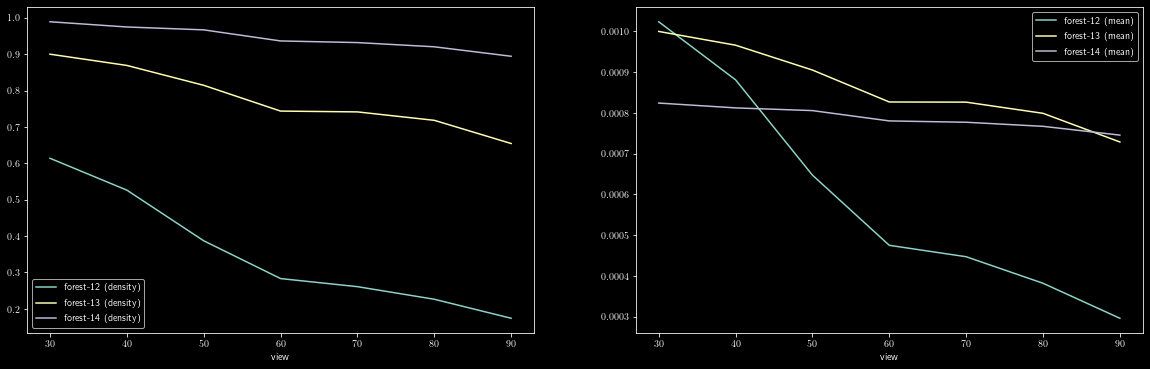

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

columns = ['density', 'mean', 'captured', 'view', 'preset', 'size']
for i, (preset, group) in enumerate(df[columns][filter_mask].groupby('preset')):
    group.plot(kind='line', x='view', y='density', label=preset + ' (density)', ax=axs[0])
    group.plot(kind='line', x='view', y='mean', label=preset + ' (mean)', ax=axs[1])
    # group.plot(kind='barh', x='view', y='captured', label=preset + ' (captured)', color=f'C{i}', ax=axs[1])

## Grounds

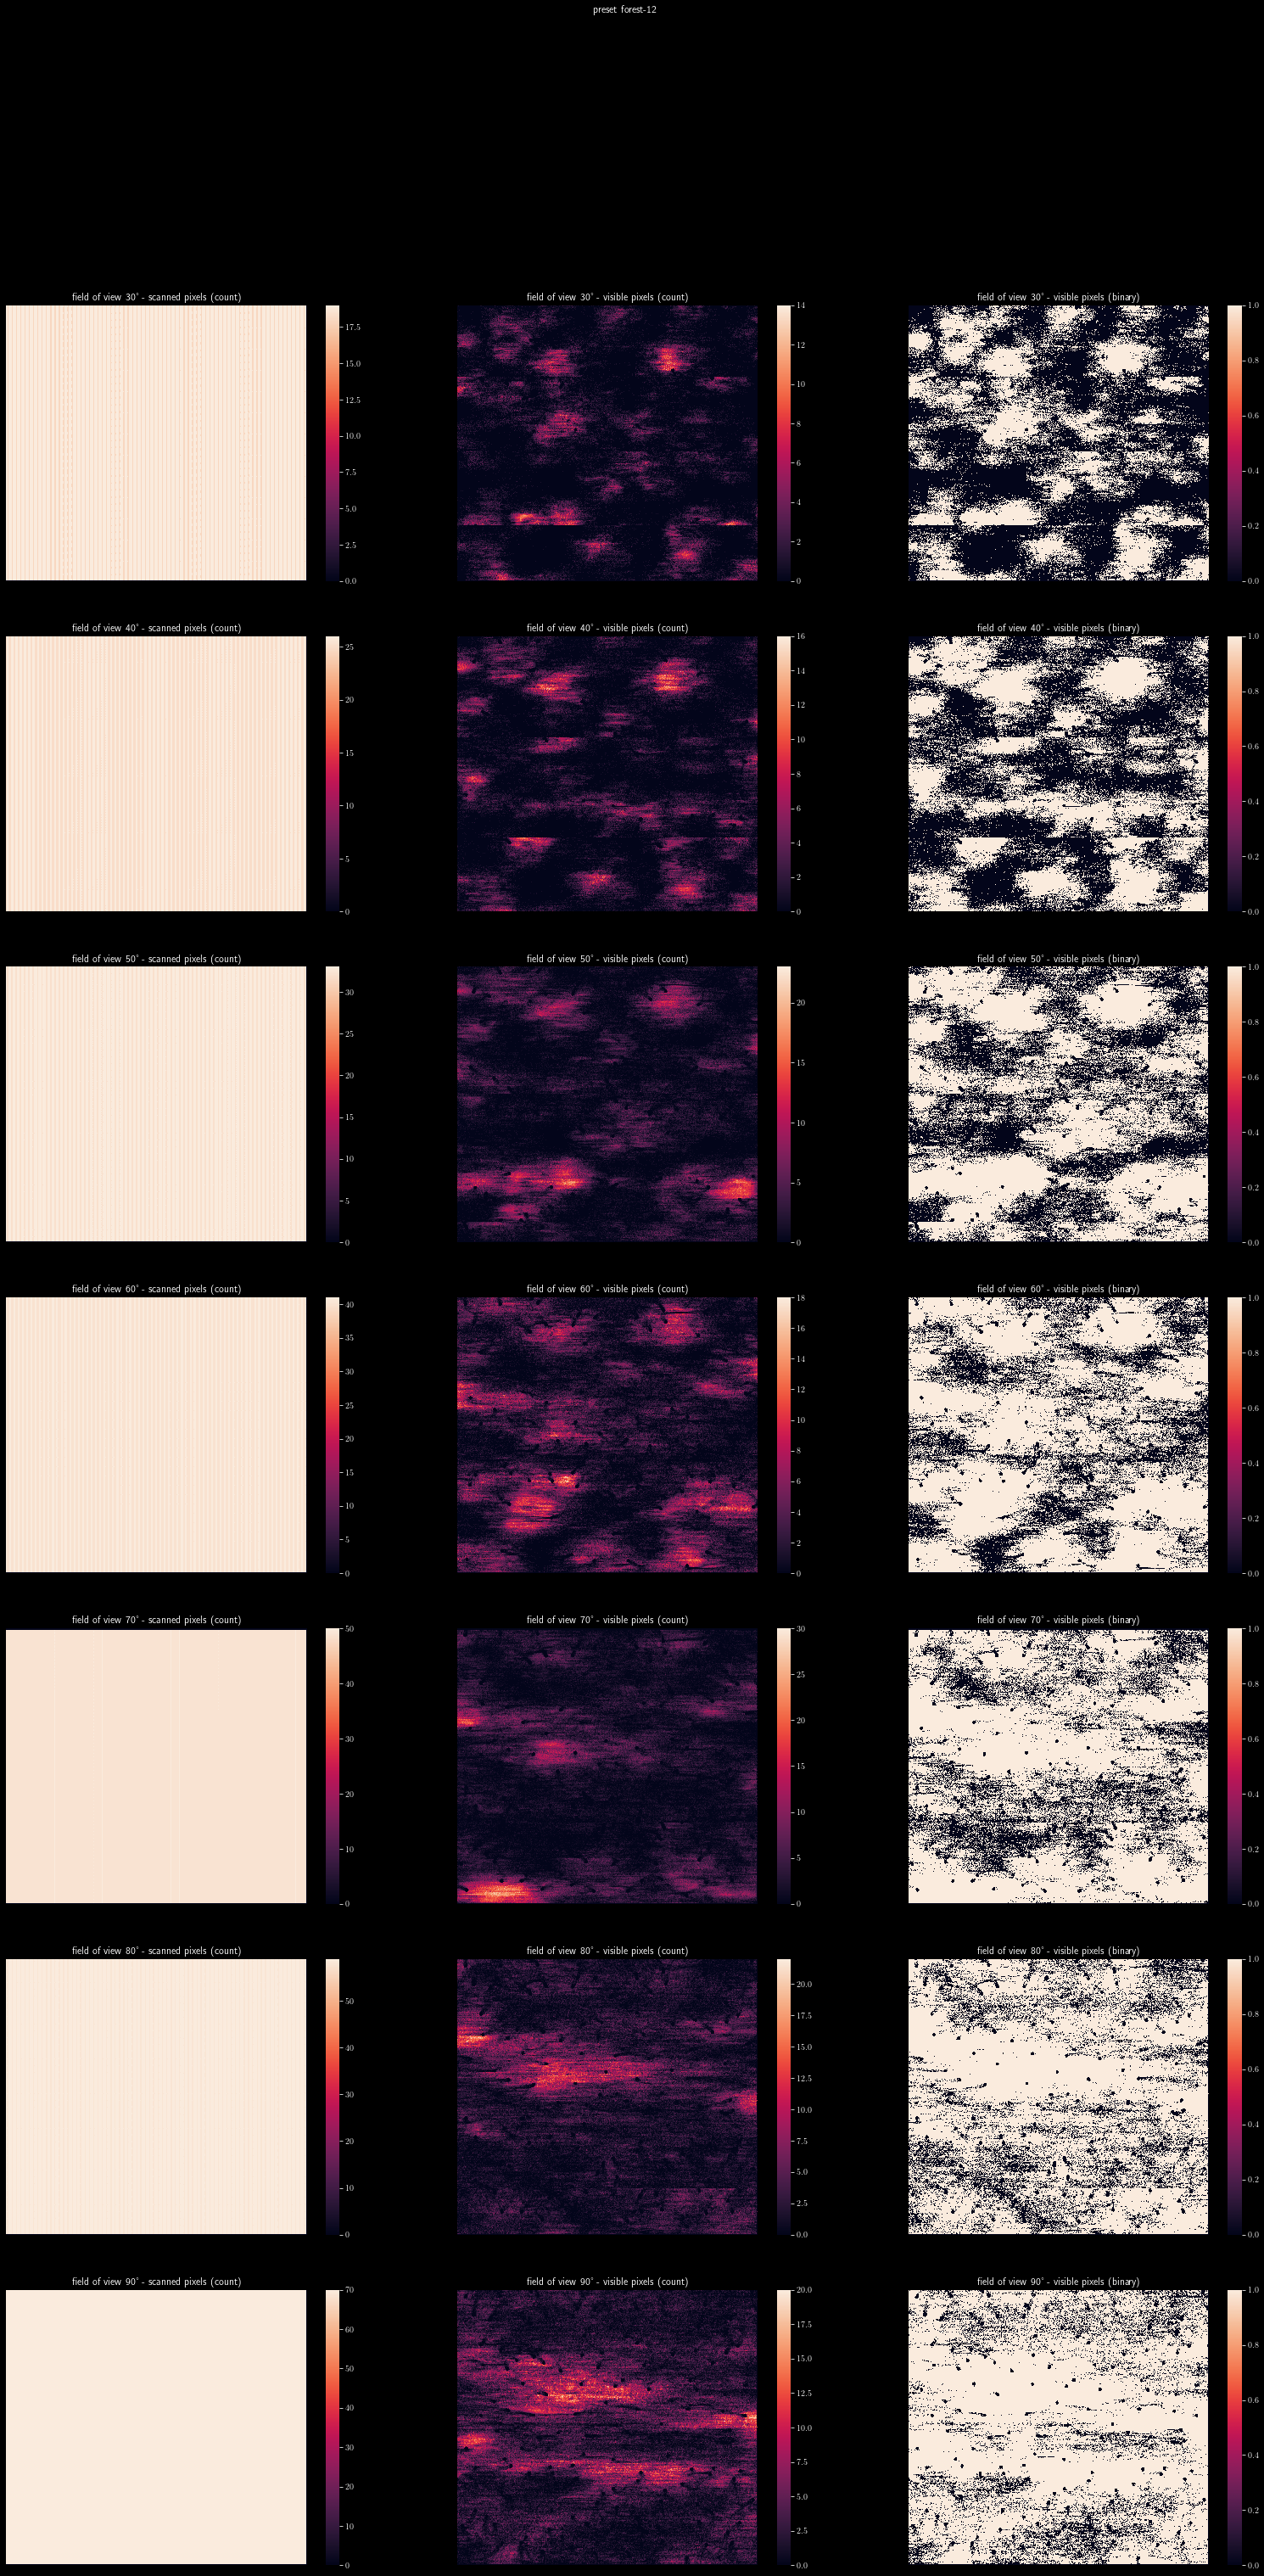

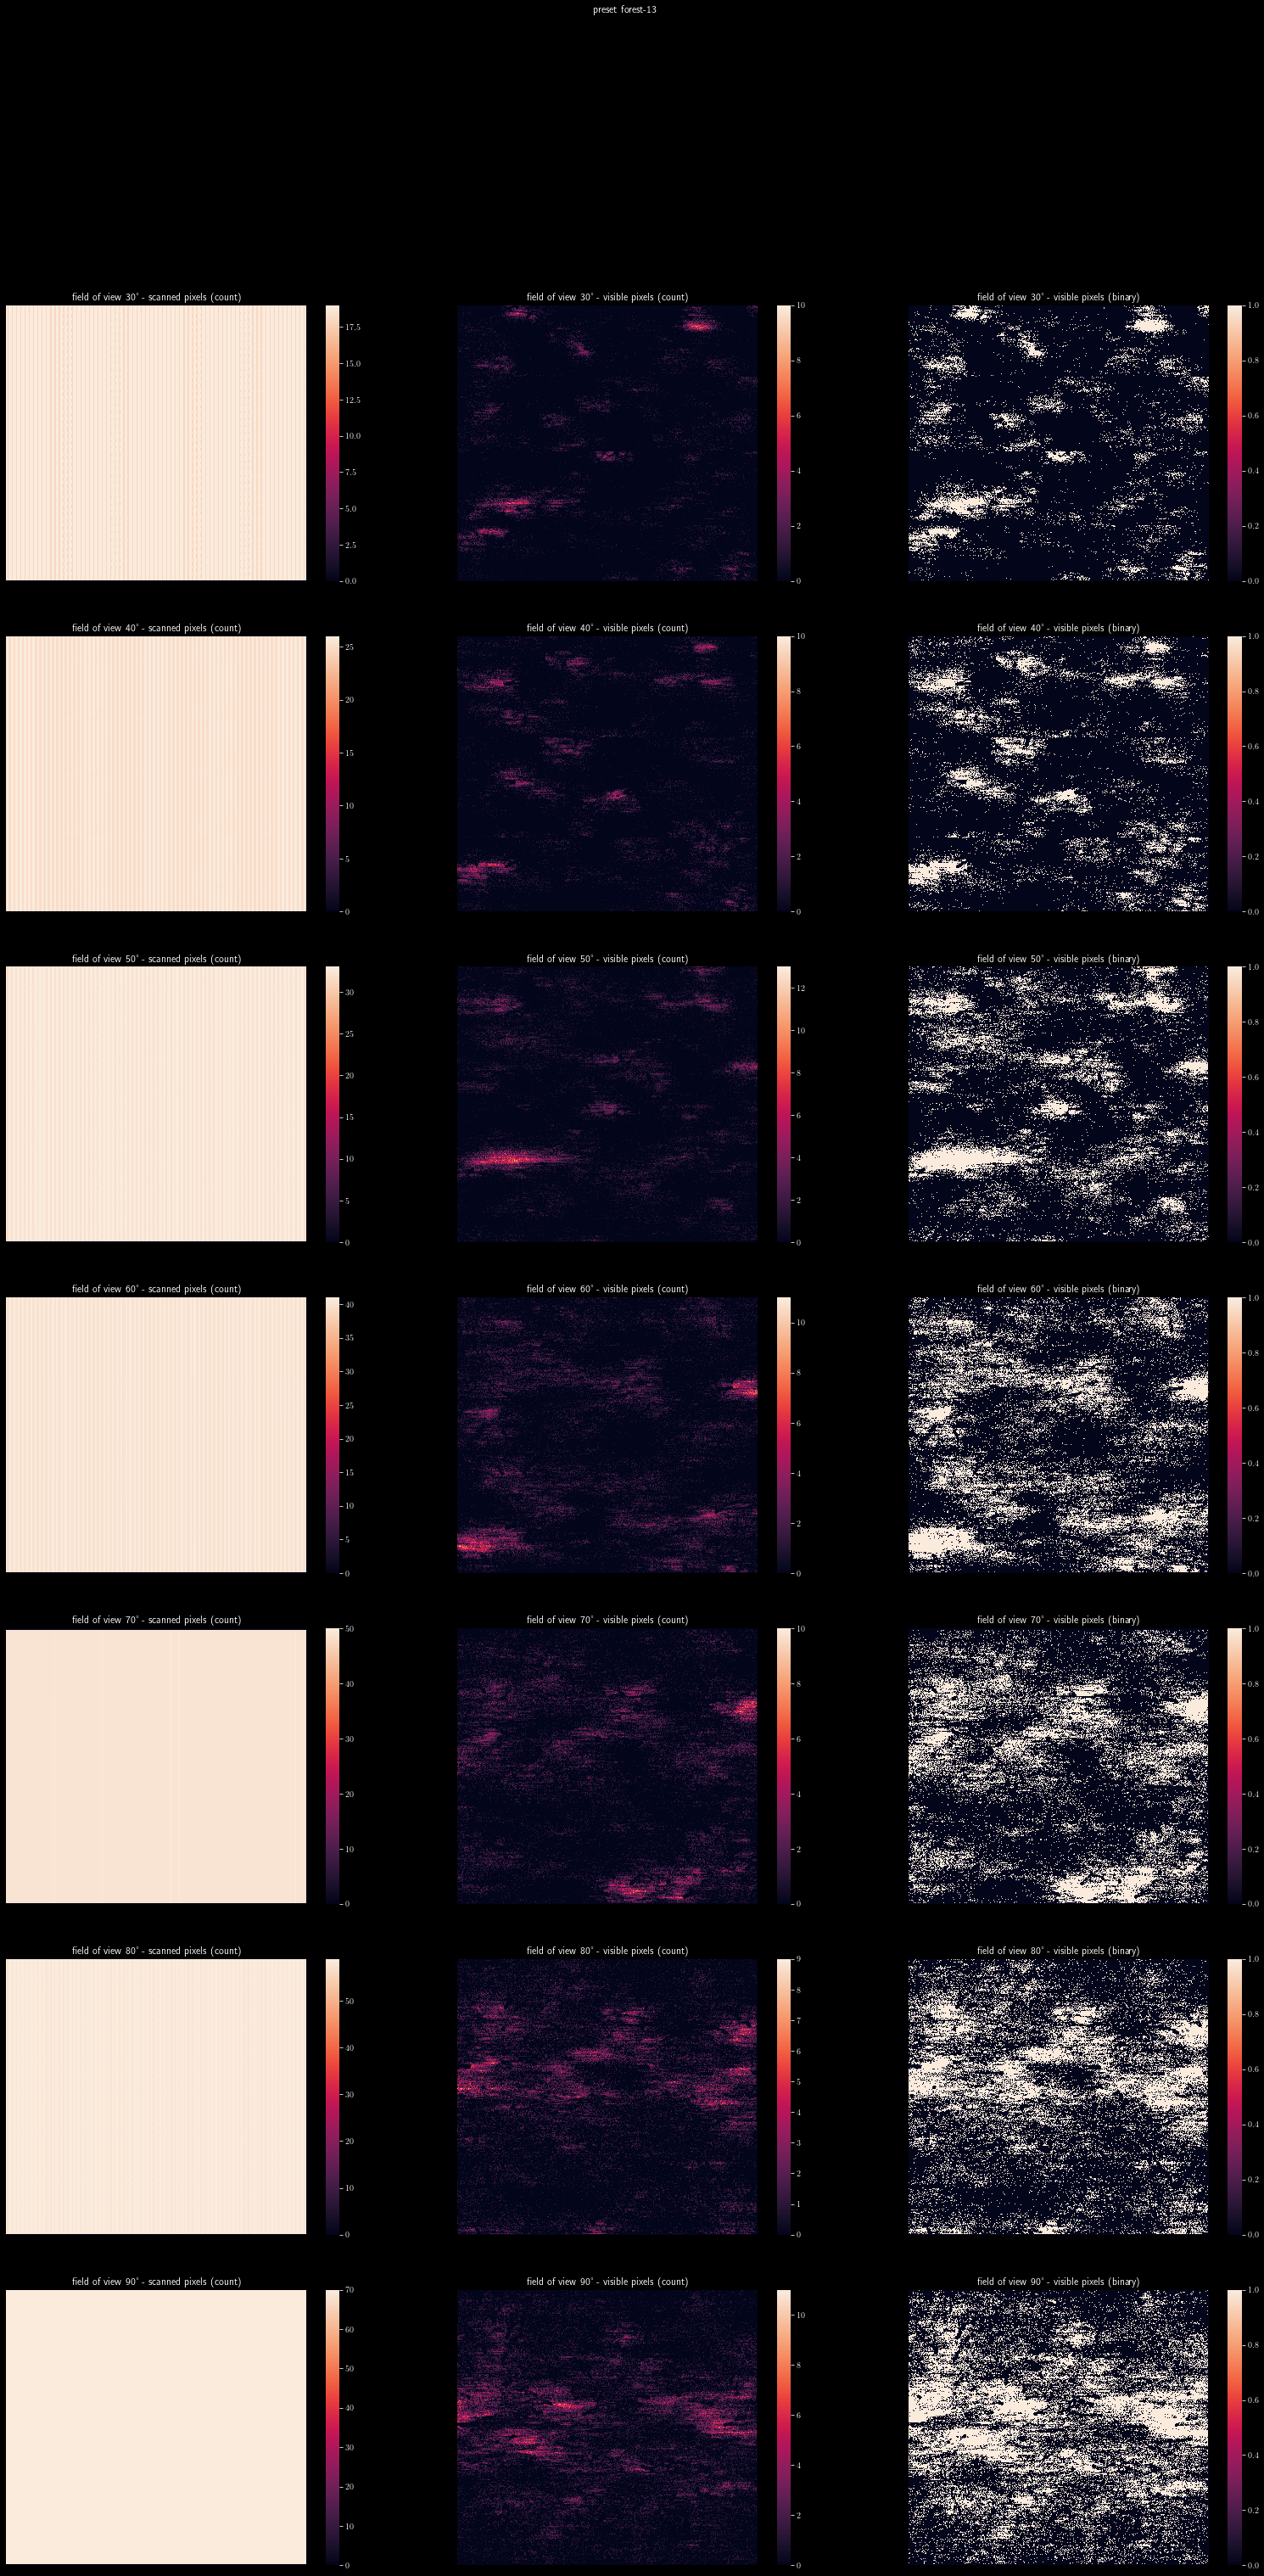

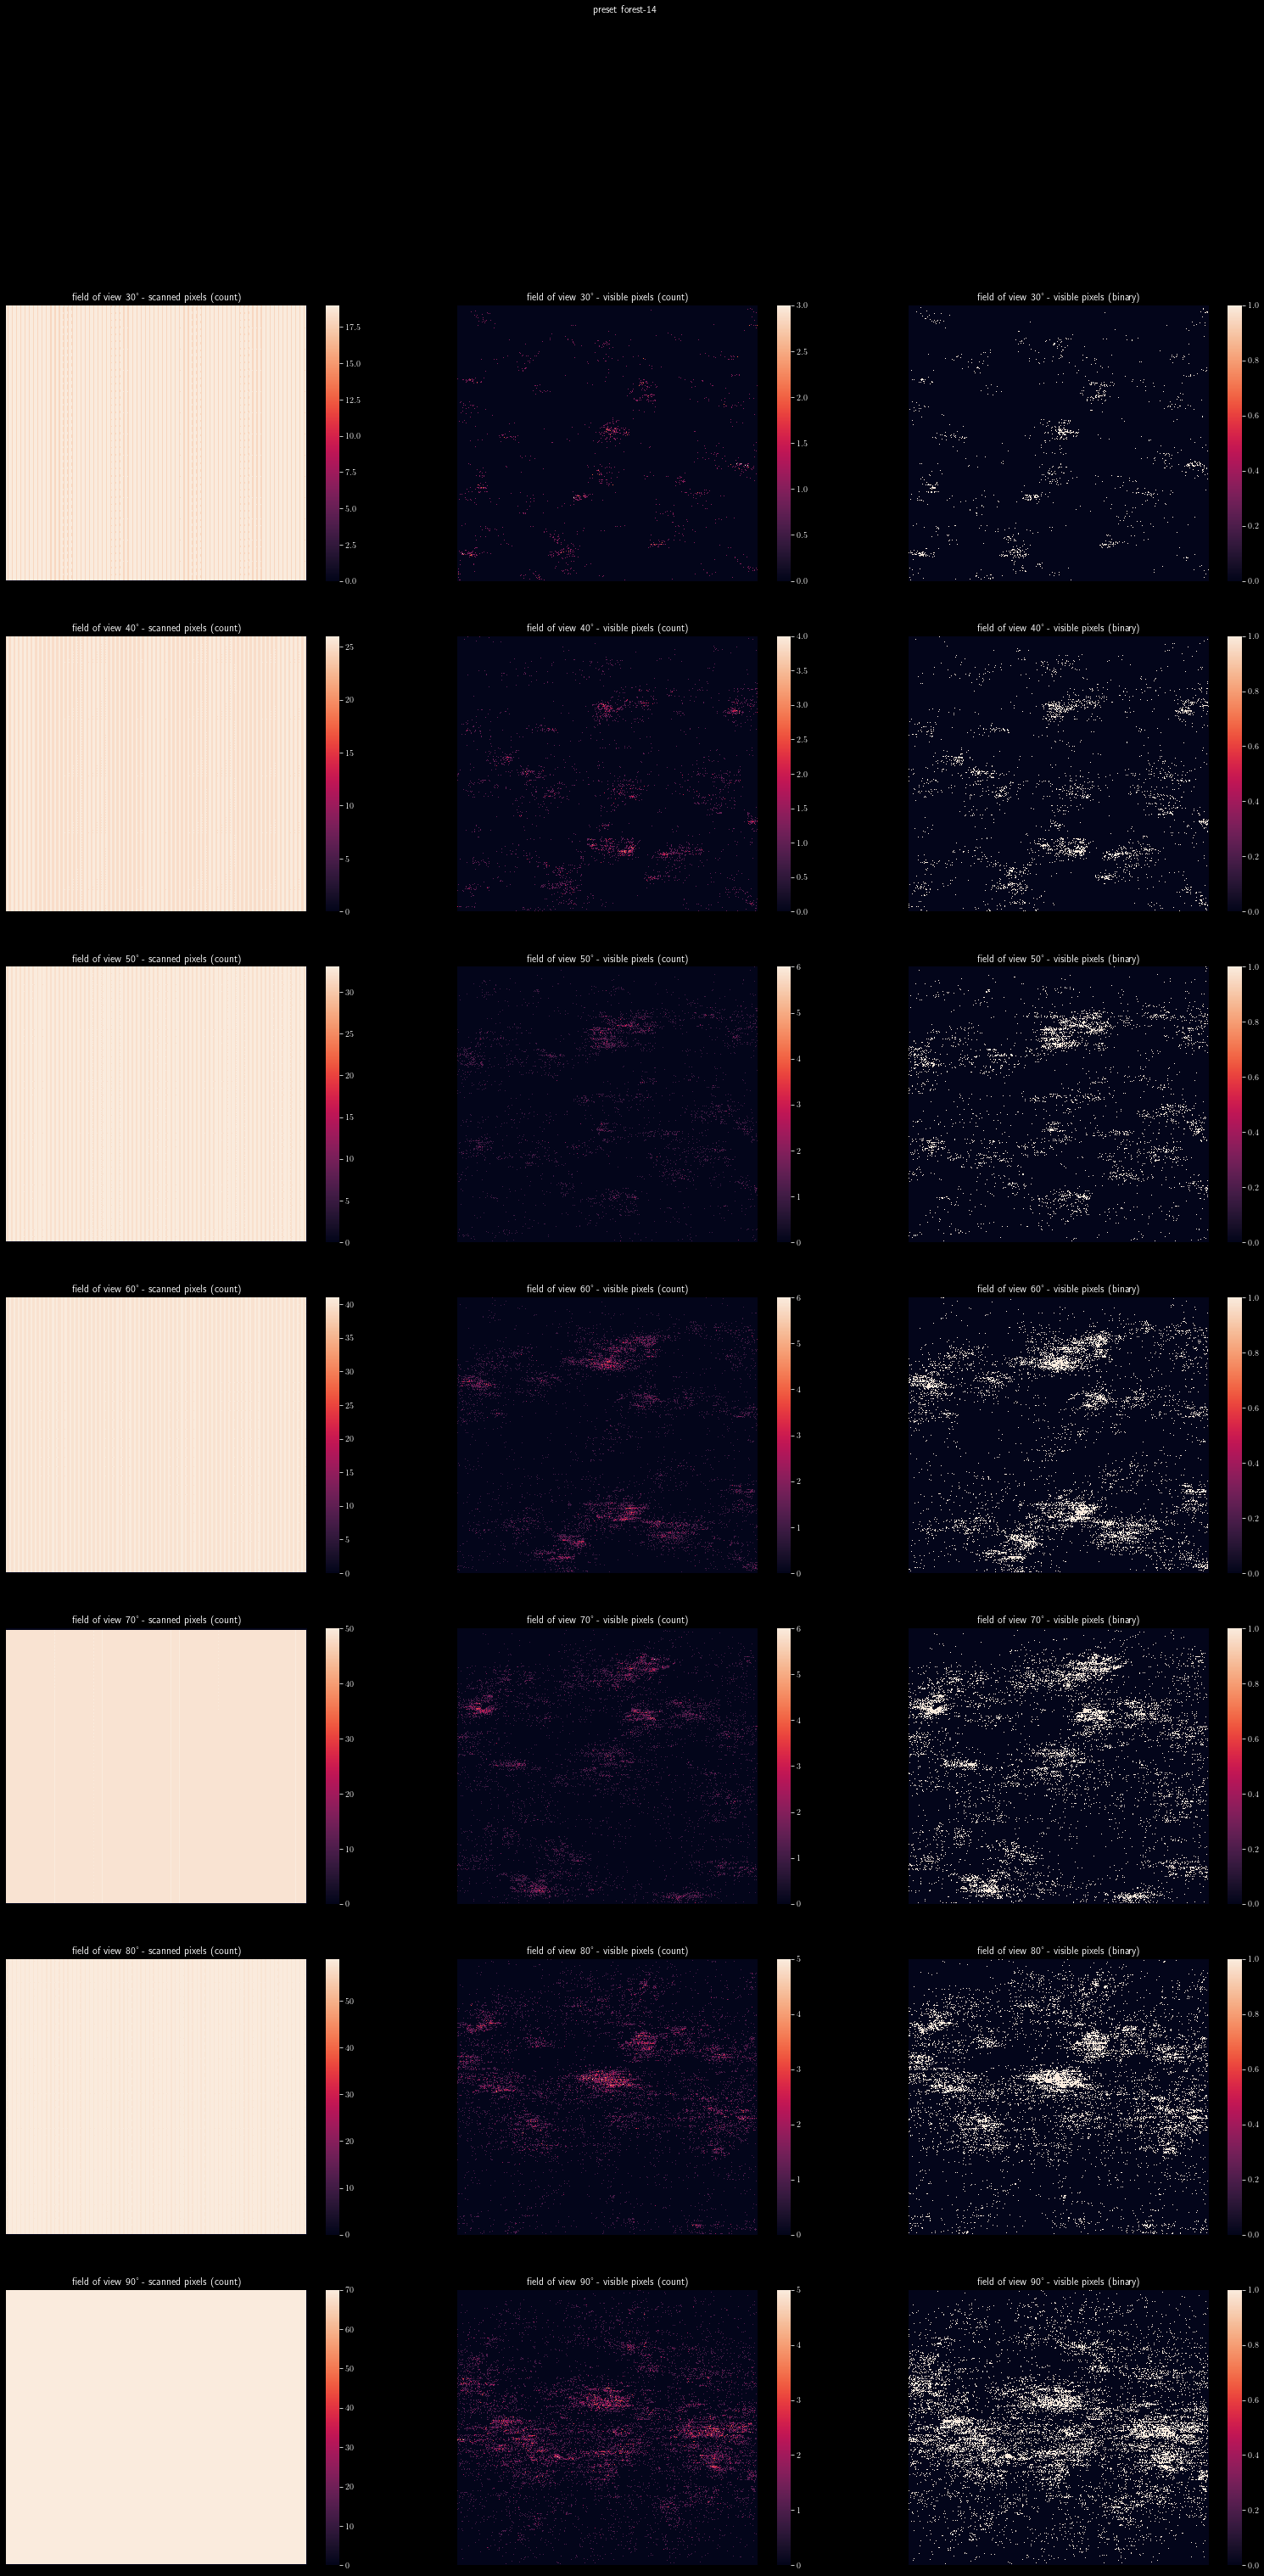

In [9]:
plot_grounds(df, filter_mask, ['preset', 'view'], 'preset %s', 'field of view %s°')

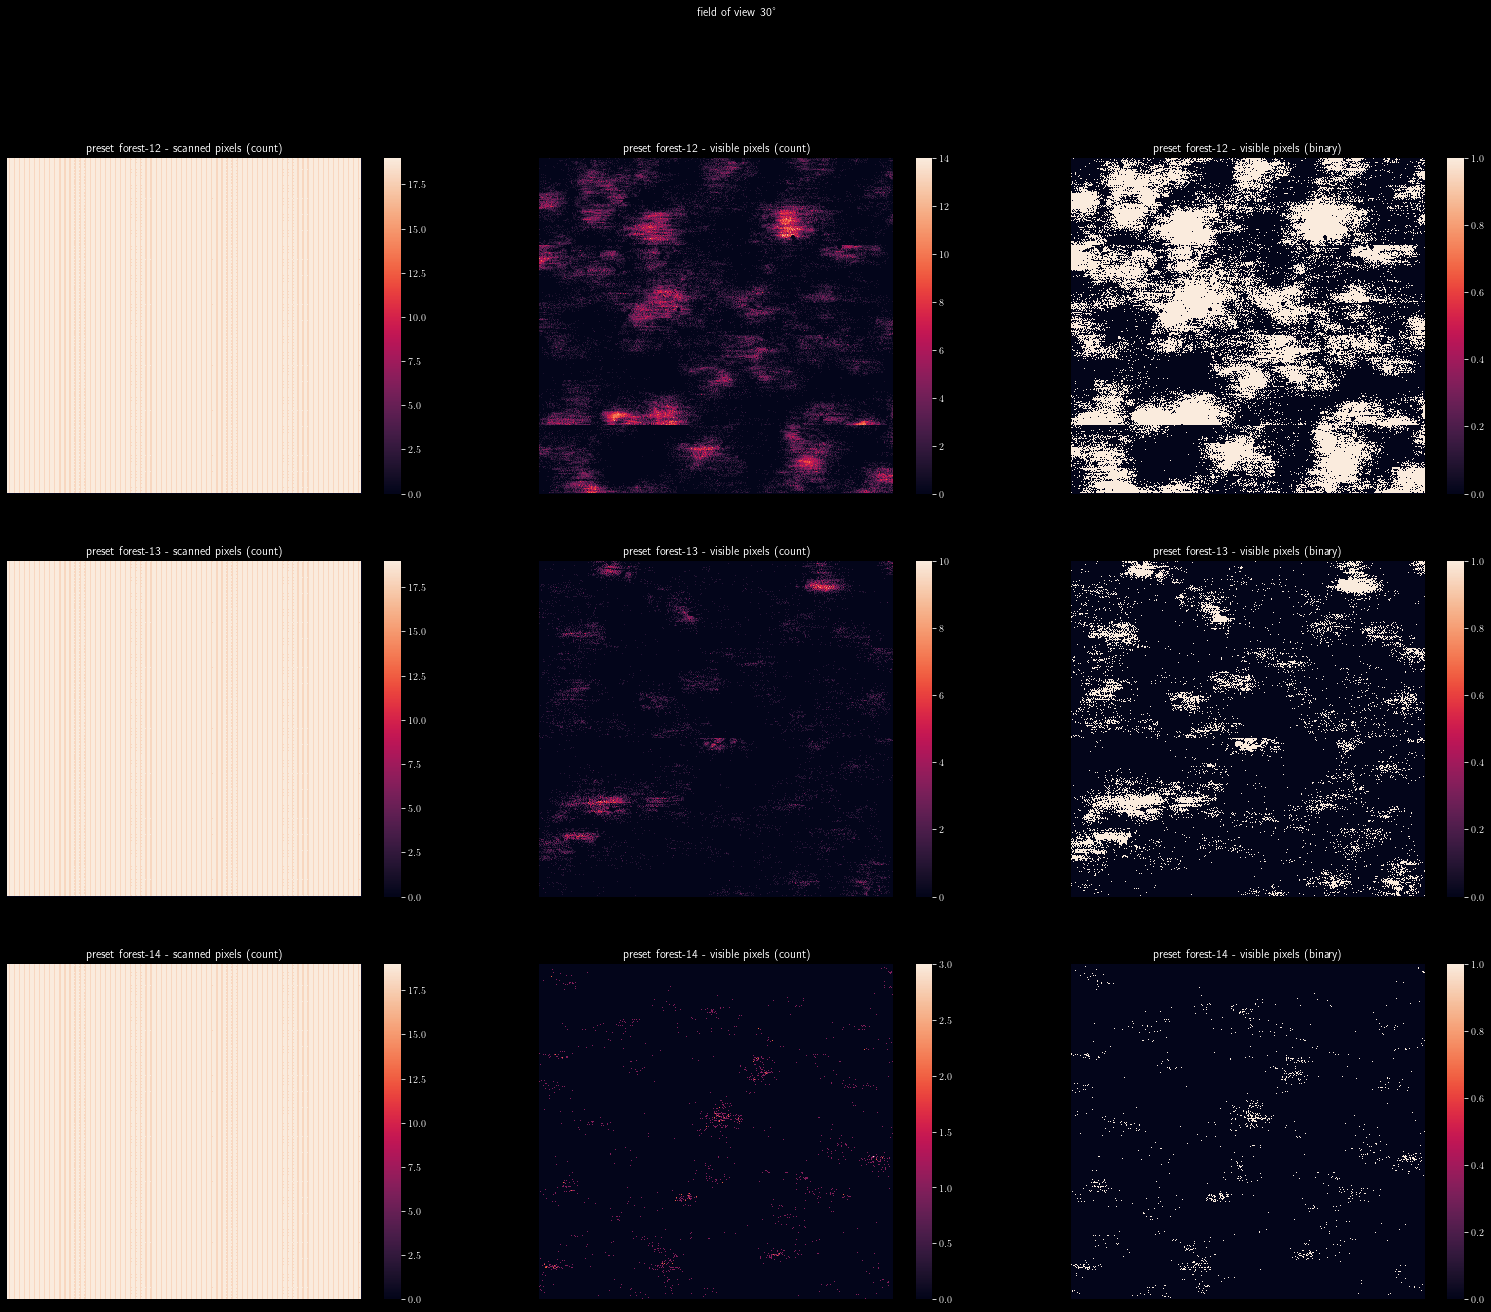

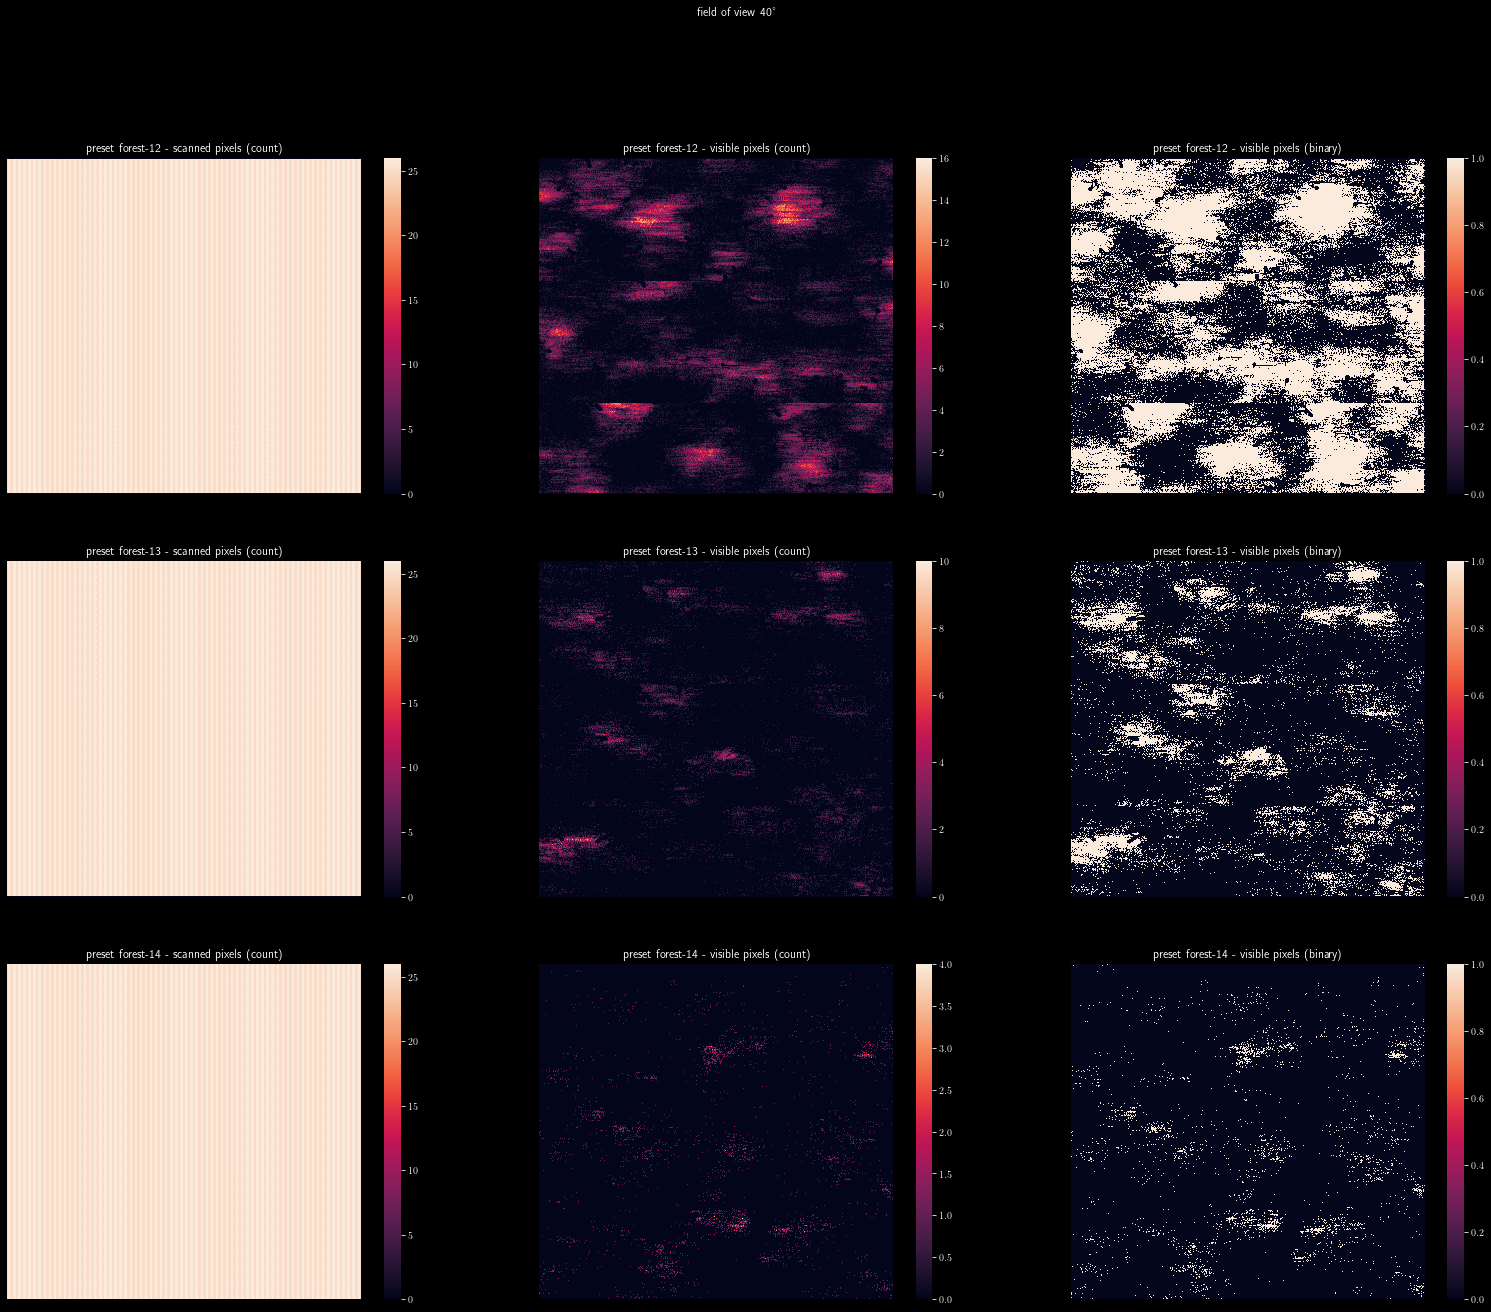

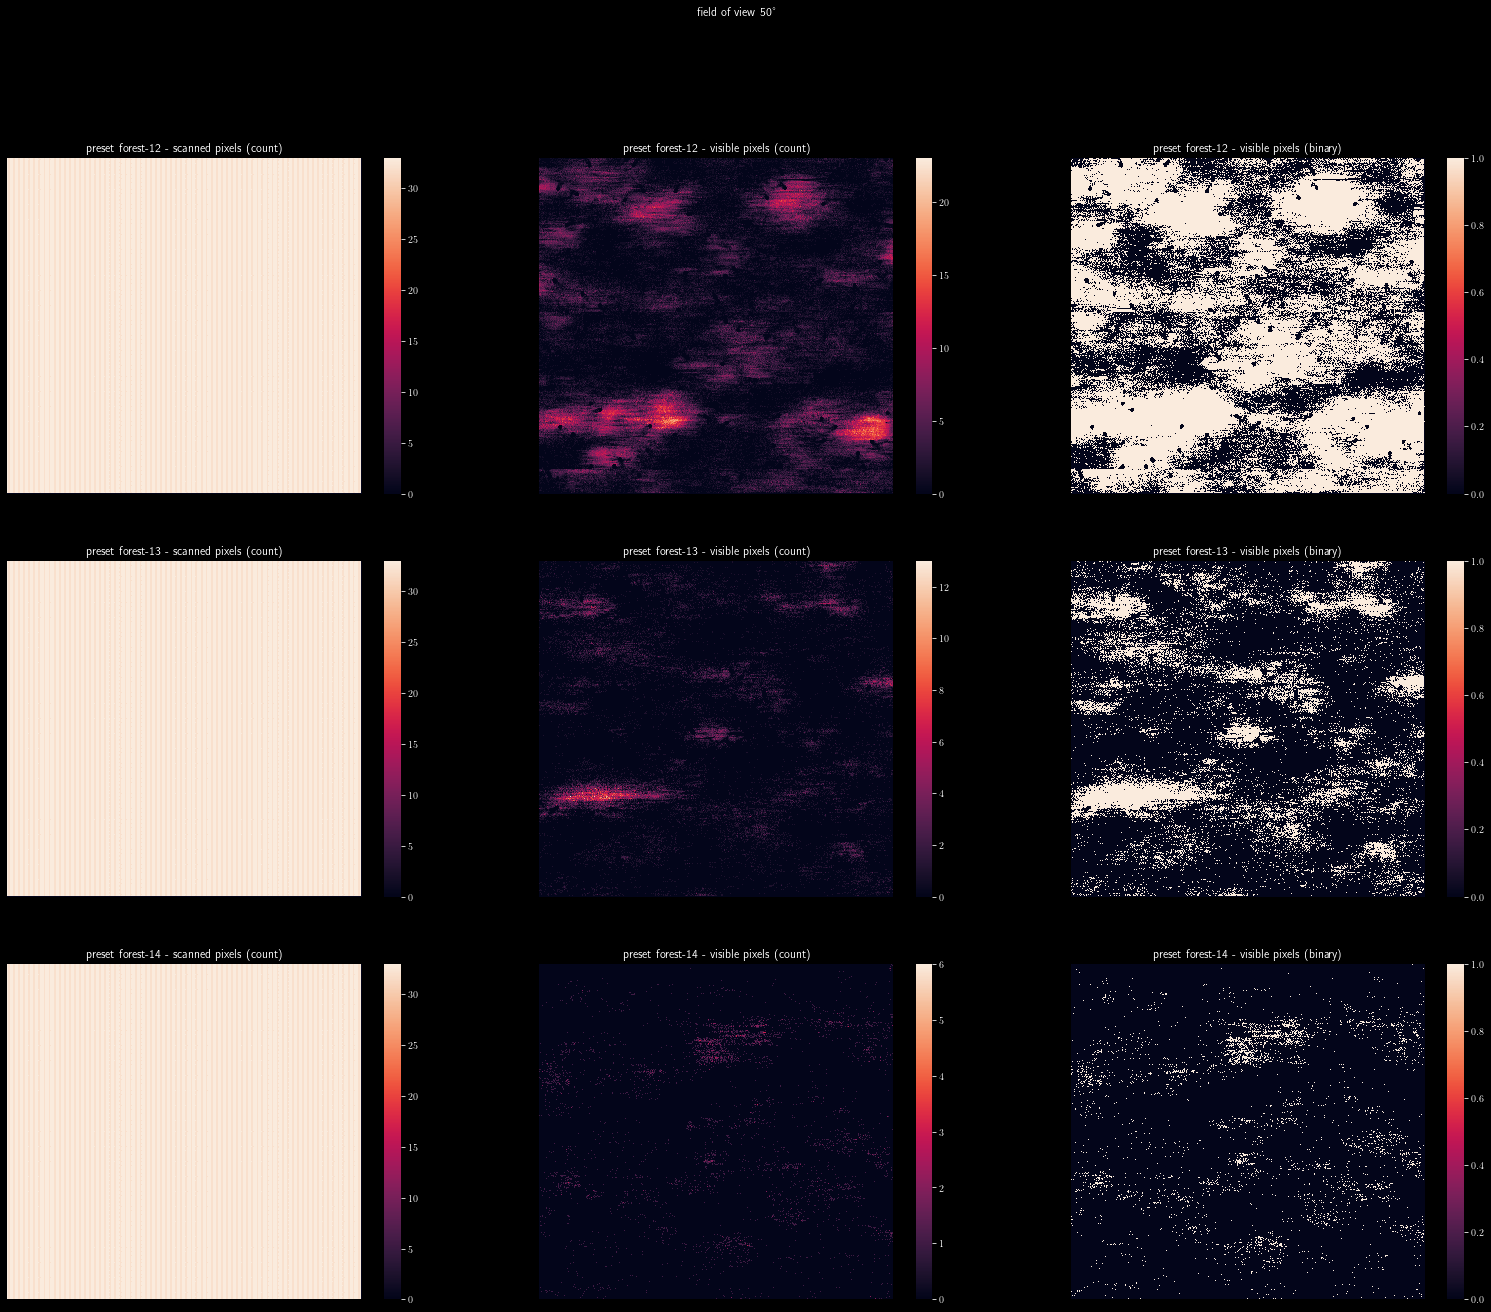

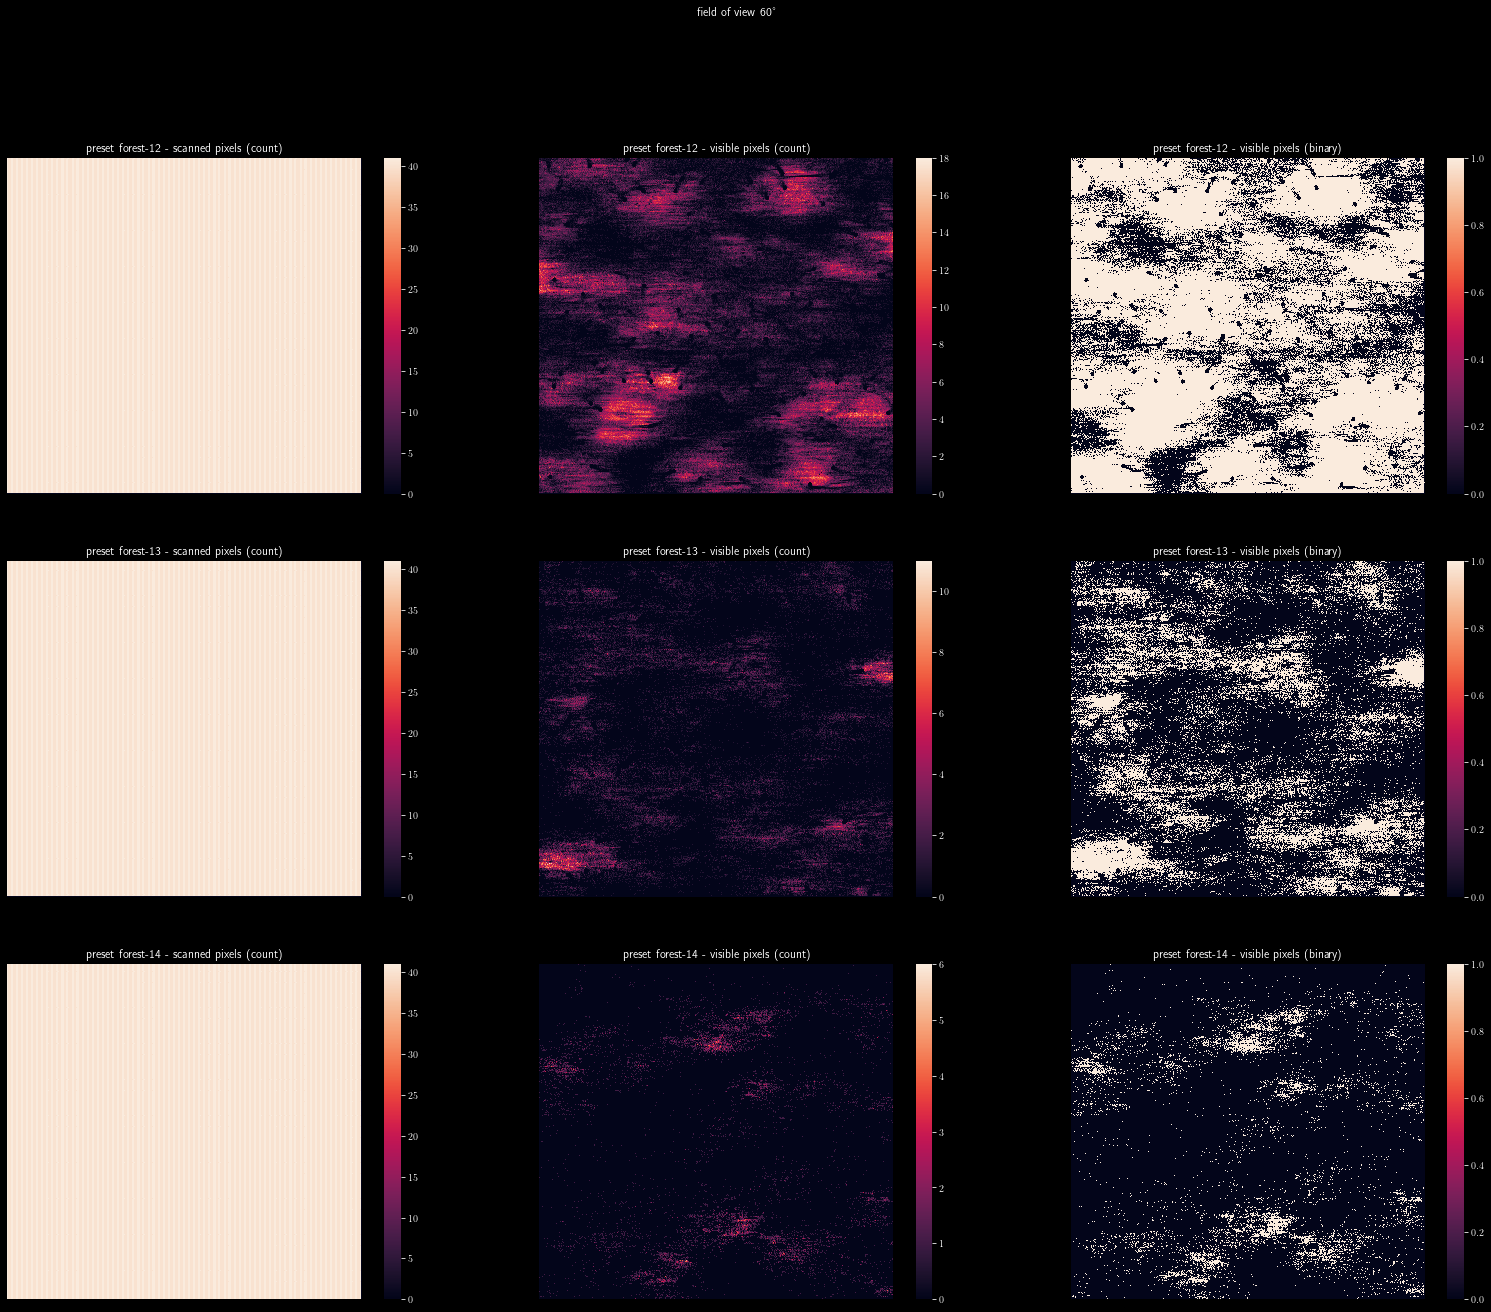

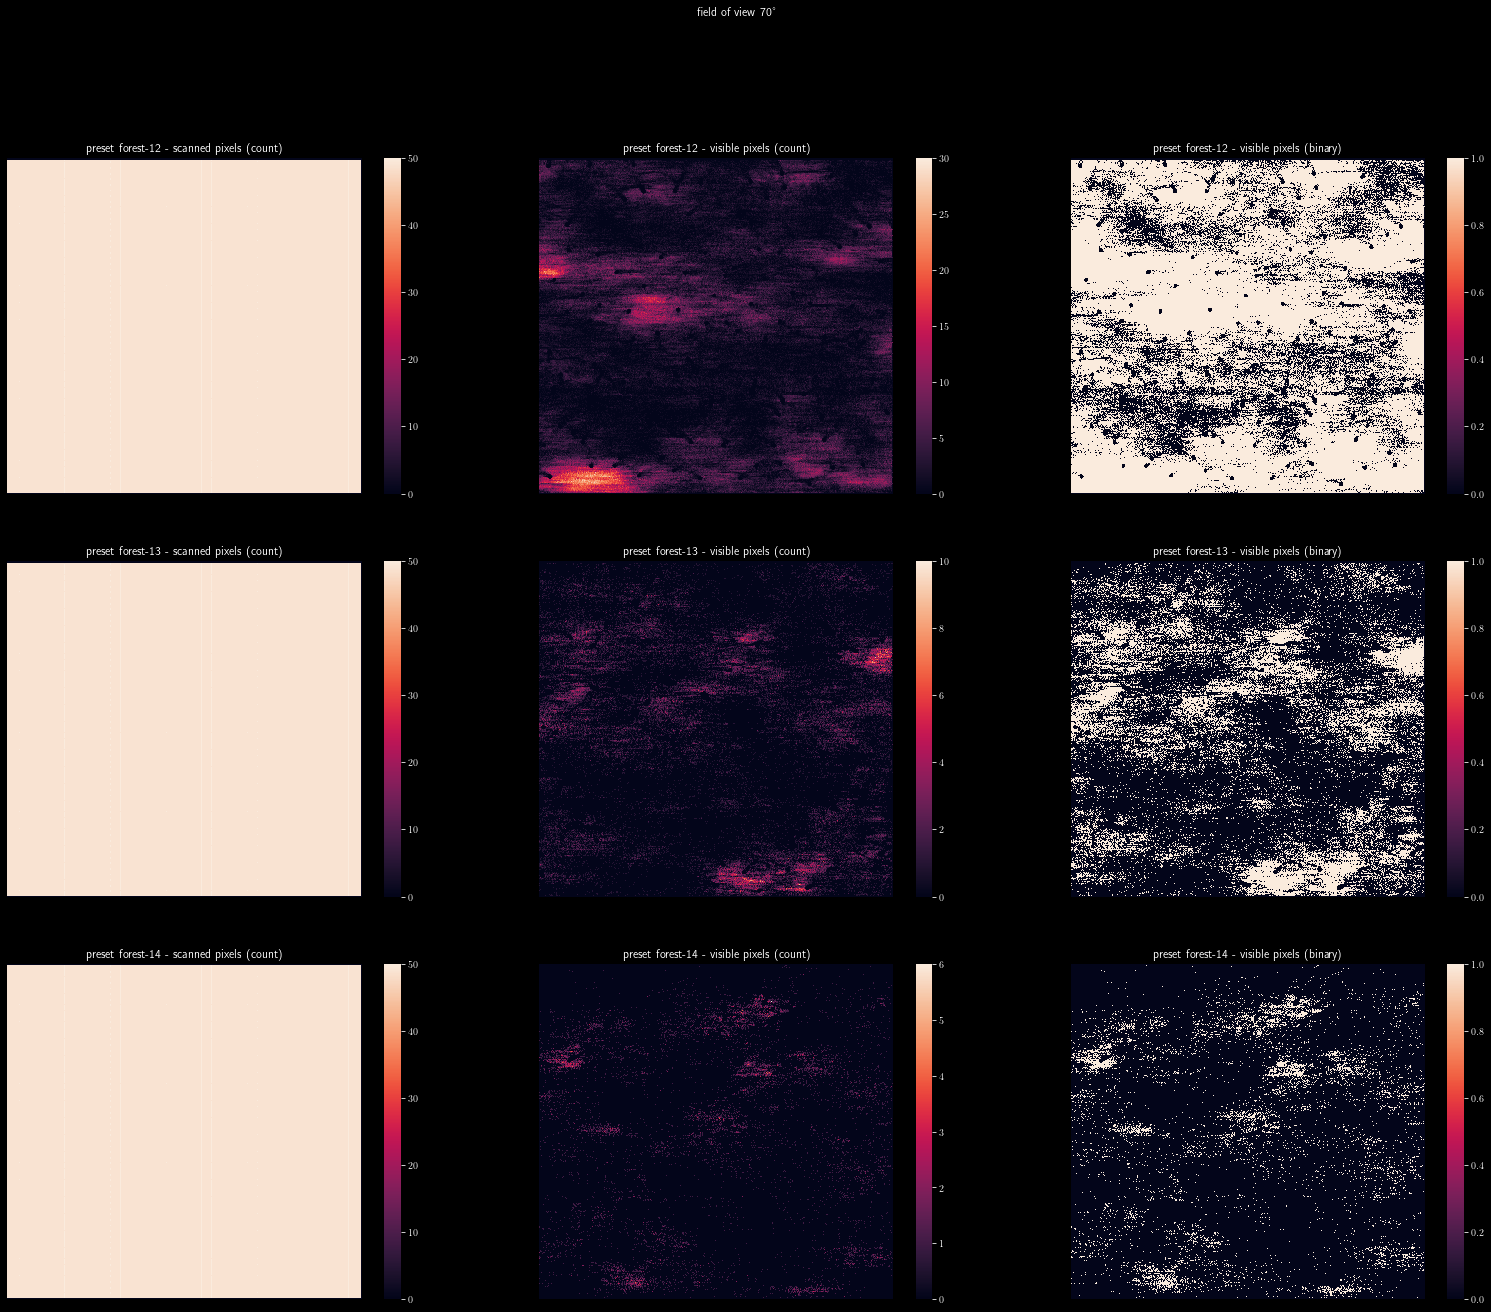

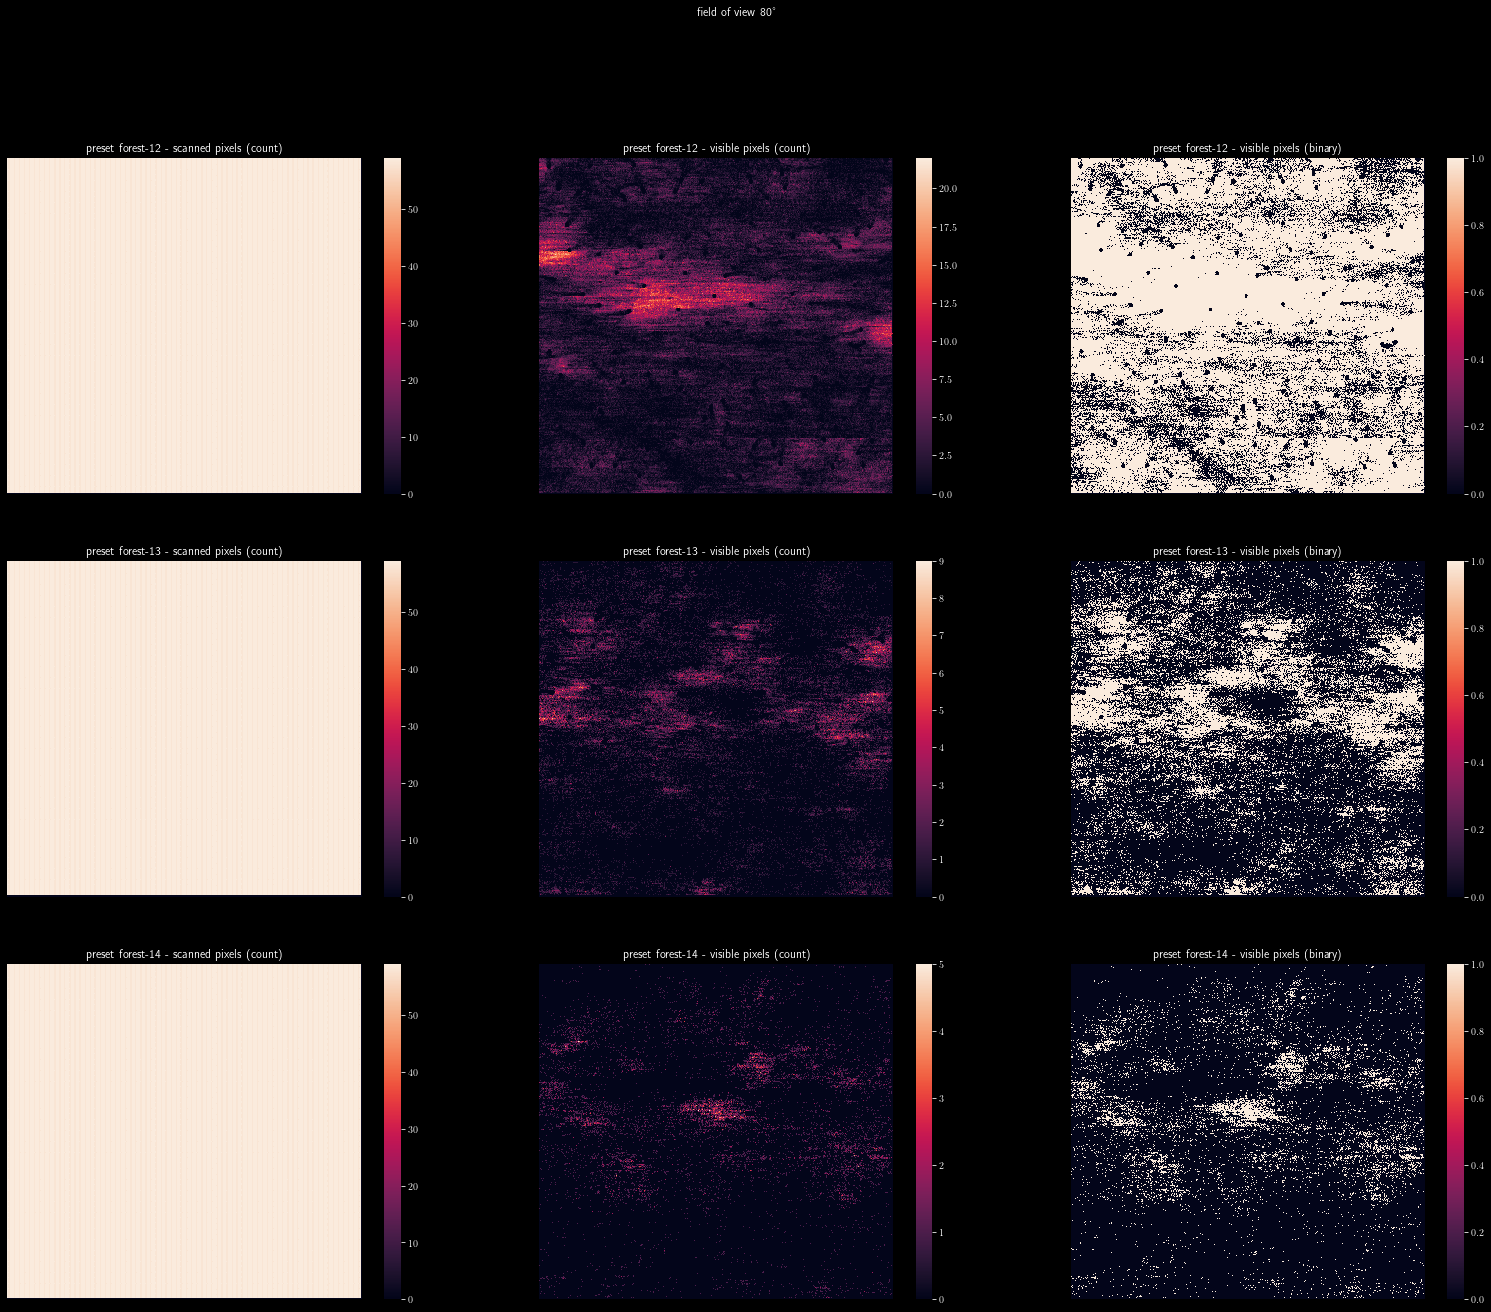

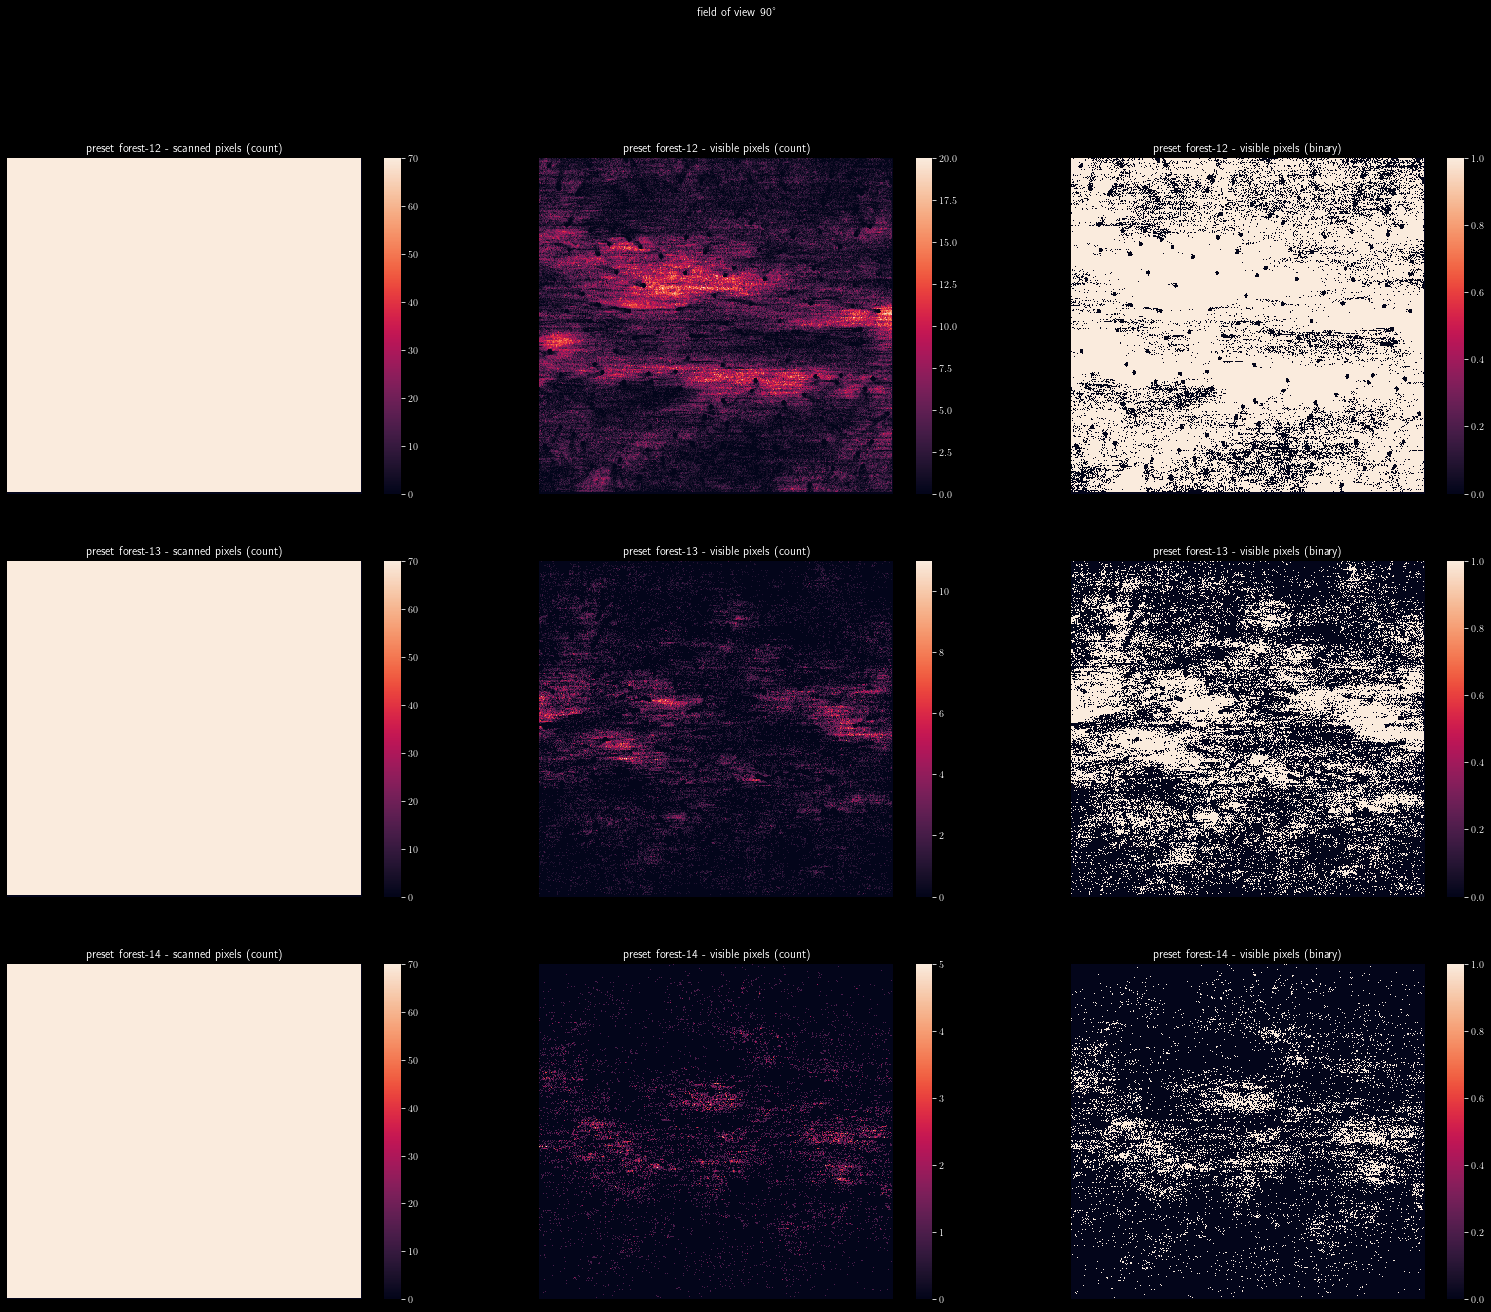

In [10]:
plot_grounds(df, filter_mask, ['view', 'preset'], 'field of view %s°', 'preset %s')

## Alphas

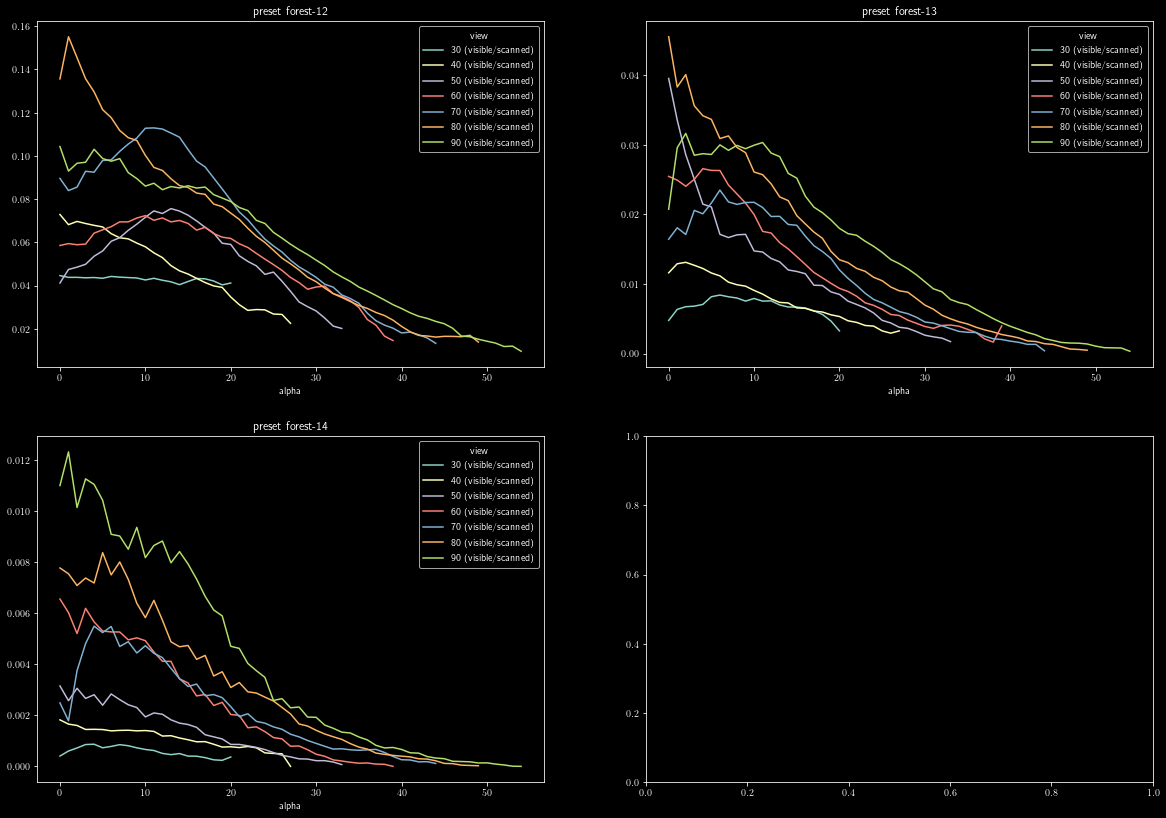

In [11]:
plot_alphas(df, filter_mask, ['preset', 'view'], 'preset %s')

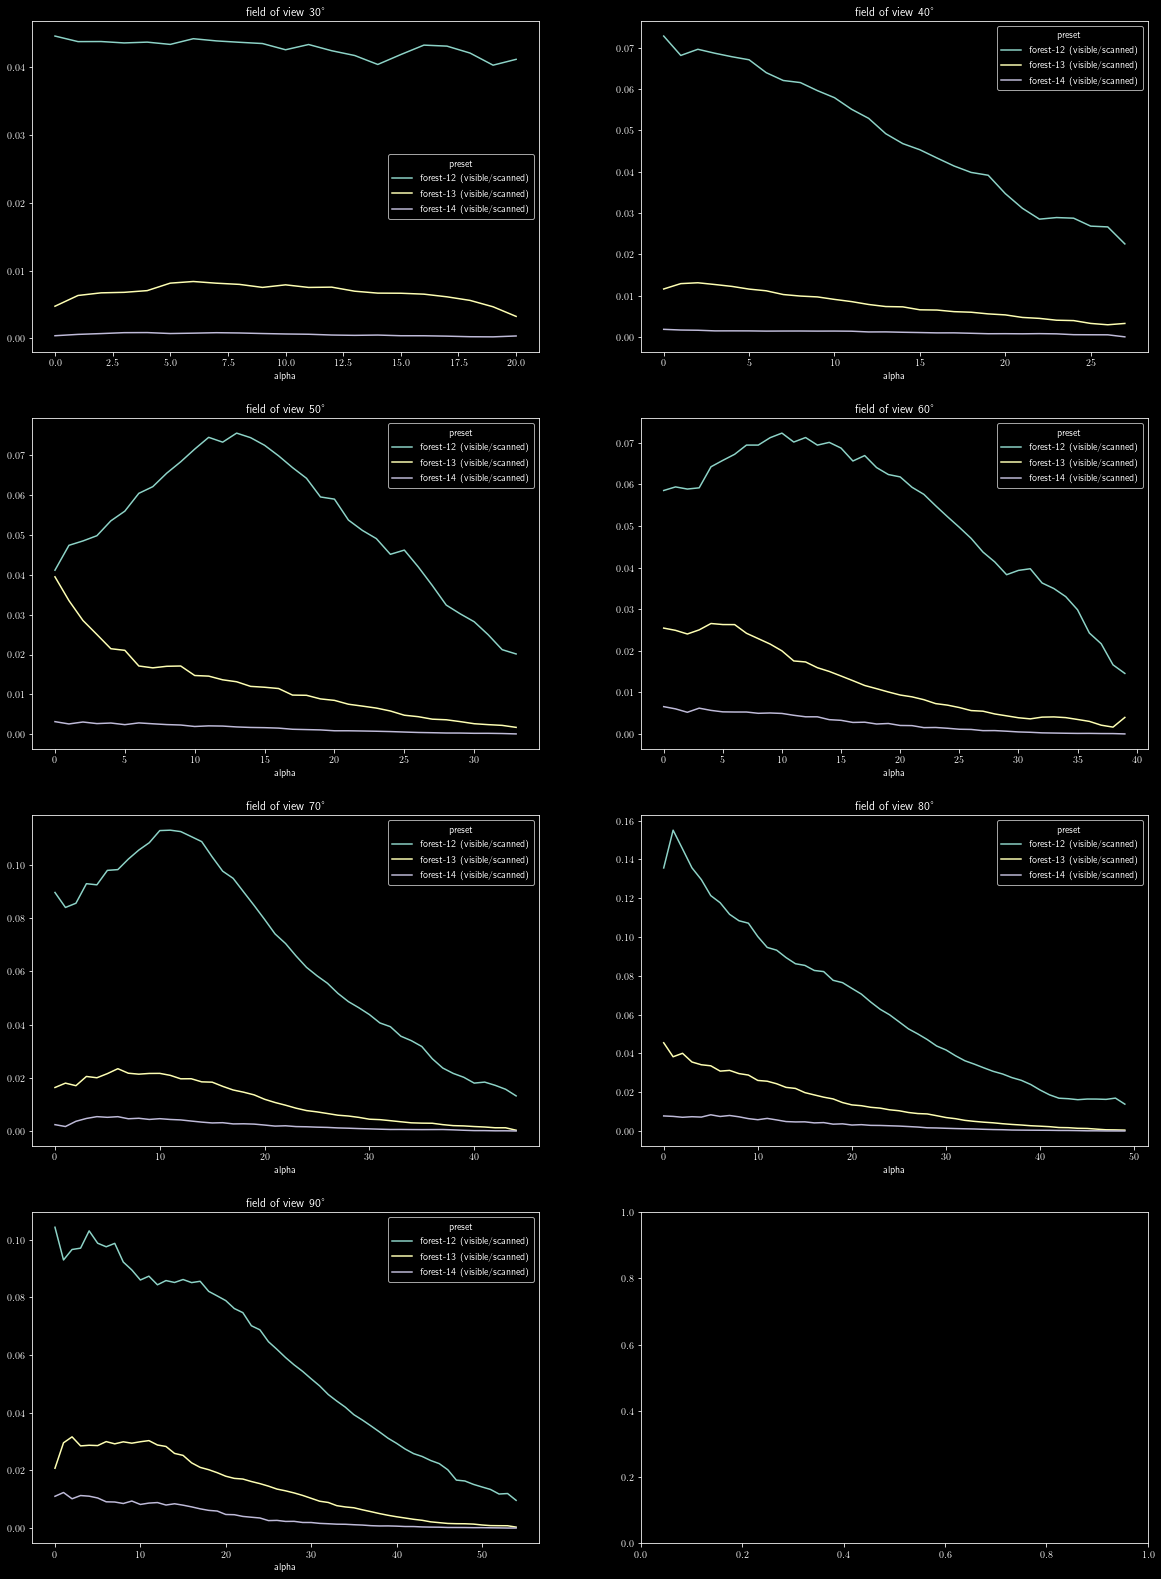

In [12]:
plot_alphas(df, filter_mask, ['view', 'preset'], 'field of view %s°')